## Importing Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt


## Web Scraping function

In [2]:

def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    reviews = soup.find_all("li", class_="review_item clearfix")
    data = []
    # Since we are fetching data from 6 different hotels
    hotel_name_element = soup.find("a", class_="standalone_header_hotel_link")
    hotel_name = hotel_name_element.text.strip() if hotel_name_element else None

    # Counting the hotel stars since they are represented by icons
    stars_element = soup.find("i", class_="bk-icon-wrapper bk-icon-stars star_track")
    if stars_element:
        stars_title = stars_element.get('title')
        # Extracting the number from the title "5 stars"
        num_stars = int(stars_title[0]) if stars_title and stars_title[0].isdigit() else None
    else:
        num_stars = None

    for review in reviews:
        # Extracting the required features
        nationality = review.find("span", itemprop="nationality").text.strip() if review.find("span", itemprop="nationality") else None
        review_score = review.find("span", class_="review-score-badge").text.strip() if review.find("span", class_="review-score-badge") else None
        reviewer_name = review.find("span", itemprop="name").text.strip() if review.find("span", itemprop="name") else None
        review_text = review.find("div", class_="review_item_header_content").text.strip() if review.find("div", class_="review_item_header_content") else None

        # Converting reviewd_on to date time since it is in the format "Reviewed on: "
        review_info_text = review.find("p", class_="review_item_date").text.strip() if review.find("p", class_="review_item_date") else None
        if review_info_text:
            review_date_str = review_info_text.replace("Reviewed: ", "")
            try:
                review_date = datetime.strptime(review_date_str, "%d %B %Y").date()
            except ValueError:
                review_date = None
        else:
            review_date = None

        # Extracting positive and negative review parts
        review_pos_element = review.find("p", class_="review_pos")
        review_pos_text = review_pos_element.find("span", itemprop="reviewBody").text.strip() if review_pos_element else None

        review_neg_element = review.find("p", class_="review_neg")
        review_neg_text = review_neg_element.find("span", itemprop="reviewBody").text.strip() if review_neg_element else None

        data.append({
            "reviewer_name": reviewer_name,
            "nationality": nationality,
            "review_score": review_score,
            "review": review_text,
            "positive_review": review_pos_text,
            "negative_review": review_neg_text,
            "review_date": review_date,
            "hotel_name": hotel_name,
            "stars": num_stars
        })

    return pd.DataFrame(data)


1. Initializing empty dataframe to combined_df variable, this dataframe will store the extracted data
2. Then defined list of URLs for 6 Leonardo hotels in Ireland to extract data from. Post which we used a 'for' loop on each of the urls since we are webscraping it from multiple pages of reviews for each hotel. Based on the domain knowledge we are scraping upto 25 pages for each hotel and each page contains approximately 25 reviews.


In [3]:

combined_df = pd.DataFrame()

# List of hotel URLs to scrape the reviews from
urls = [
    #NYX Hotel Dublin
    "https://www.booking.com/reviews/ie/hotel/nyx-dublin-portobello.en-gb.html?aid=356980&label=gog235jc-1FCA0oaUIVbnl4LWR1Ymxpbi1wb3J0b2JlbGxvSDNYA2hpiAEBmAEJuAEHyAEM2AEB6AEB-AEMiAIBqAIDuALFhsGwBsACAdICJDE0MjIwZmRhLTcyYjctNGMyMy1hMGQ4LTQ0NzRjODA3NzRmYdgCBuACAQ&sid=d86df63284be7f03d82b33d53c95f879&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&",
    #Leonardo Dublin Christchurch
    "https://www.booking.com/reviews/ie/hotel/jurysinnchristchurch.en-gb.html?aid=356980&label=gog235jc-1DCA0oaUIUanVyeXNpbm5jaHJpc3RjaHVyY2hICVgDaGmIAQGYAQm4AQfIAQzYAQPoAQH4AQKIAgGoAgO4AriFwbAGwAIB0gIkZDU2OWRmN2MtOTc2Yy00MWViLWFmMjctY2QxNzBiYzczNmRk2AIE4AIB&sid=d86df63284be7f03d82b33d53c95f879&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&",
    #Leonardo Dublin Parnell
    "https://www.booking.com/reviews/ie/hotel/jurysinnparnellst.en-gb.html?aid=356980&label=gog235jc-1FCA0oaUIRanVyeXNpbm5wYXJuZWxsc3RIM1gDaGmIAQGYAQm4ARfIAQzYAQHoAQH4AQyIAgGoAgO4Ap2FwbAGwAIB0gIkOGMzMmU5ZTUtMTY2NC00NGU3LWE0NDMtY2IzZjkxZmYzMDk42AIG4AIB&sid=9a6f8d9588ce04b7d8ffab6c1dc3c6fb&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&",
    #Leonardo Galway
    "https://www.booking.com/reviews/ie/hotel/jurys-inn-galway.en-gb.html?aid=356980&label=gog235jc-1DCA0oaUIQanVyeXMtaW5uLWdhbHdheUgJWANoaYgBAZgBCbgBF8gBDNgBA-gBAfgBAogCAagCA7gCmYTBsAbAAgHSAiRjODg5ZGQ2Mi05NjlhLTRhYmMtYjk0MS03NmJmYmRjM2M0NTTYAgTgAgE&sid=9a6f8d9588ce04b7d8ffab6c1dc3c6fb&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&",
    #Leonardo Cork
    "https://www.booking.com/reviews/ie/hotel/jurys-inn-cork.en-gb.html?aid=356980&label=gog235jc-1FCA0oaUIOanVyeXMtaW5uLWNvcmtIM1gDaGmIAQGYAQm4ARfIAQzYAQHoAQH4AQyIAgGoAgO4At-EwbAGwAIB0gIkMjk5Yjc2OTEtYWRkOS00MjEzLWEzNDItMDgwZGIxNTVmMGZk2AIG4AIB&sid=9a6f8d9588ce04b7d8ffab6c1dc3c6fb&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&",
    #Leonardo Belfast
    "https://www.booking.com/reviews/gb/hotel/leonardo-hotel-belfast.en-gb.html?aid=356980&label=gog235jc-1DCA0oUEIWbGVvbmFyZG8taG90ZWwtYmVsZmFzdEgJWANoaYgBAZgBCbgBB8gBDNgBA-gBAfgBAogCAagCA7gCwd_HsAbAAgHSAiRjYTBmNjRkZS1lNDM0LTQyM2MtOTY4Zi1kNjU3OTkzMjEwNTnYAgTgAgE&sid=d86df63284be7f03d82b33d53c95f879&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&"

]

# Iterating through each URL in the list
for url in urls:
    for page_num in range(1, 25):
        current_page_url = url.replace("page=1", f"page={page_num}")
        response = requests.get(current_page_url)
        if response.status_code == 200:
            df = scrape_page(response.url)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            print(f"Failed to scrape page {page_num} from URL: {url}. Status code: {response.status_code}")
    print(f"Scraped pages from URL: {url}")


Scraped pages from URL: https://www.booking.com/reviews/ie/hotel/nyx-dublin-portobello.en-gb.html?aid=356980&label=gog235jc-1FCA0oaUIVbnl4LWR1Ymxpbi1wb3J0b2JlbGxvSDNYA2hpiAEBmAEJuAEHyAEM2AEB6AEB-AEMiAIBqAIDuALFhsGwBsACAdICJDE0MjIwZmRhLTcyYjctNGMyMy1hMGQ4LTQ0NzRjODA3NzRmYdgCBuACAQ&sid=d86df63284be7f03d82b33d53c95f879&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&
Scraped pages from URL: https://www.booking.com/reviews/ie/hotel/jurysinnchristchurch.en-gb.html?aid=356980&label=gog235jc-1DCA0oaUIUanVyeXNpbm5jaHJpc3RjaHVyY2hICVgDaGmIAQGYAQm4AQfIAQzYAQPoAQH4AQKIAgGoAgO4AriFwbAGwAIB0gIkZDU2OWRmN2MtOTc2Yy00MWViLWFmMjctY2QxNzBiYzczNmRk2AIE4AIB&sid=d86df63284be7f03d82b33d53c95f879&customer_type=total&hp_nav=0&old_page=0&order=featuredreviews&page=1&r_lang=en&rows=75&
Scraped pages from URL: https://www.booking.com/reviews/ie/hotel/jurysinnparnellst.en-gb.html?aid=356980&label=gog235jc-1FCA0oaUIRanVyeXNpbm5wYXJuZWxsc3RIM1gDaGmIAQGYAQm4ARfIAQzYAQHoAQH4AQyIA

## Preprocessing

Now as all the records are present in dataframe (combined_df : variables) we use the below code to preprocess the data. First it converts the review_score into float datatype and rounds it upto 1 decimal place. It then filters out all the records from the dataframe which have review score greater that 8.0 as to focus on negative reviews. Then we removed all the rows where the negative_review column where is empty. The negative review column also has emojis and quotes which is removed by the "remove_emoticons_quotes" function.

In [4]:
# Converting 'Review Score' to float
combined_df['review_score'] = combined_df['review_score'].astype(float).round(1)

# Removing rows with 'Review Score' above 8.0
combined_df = combined_df[combined_df['review_score'] < 8.0]

# Removing rows where 'Negative Review' is None, empty, or contains only whitespace
combined_df = combined_df[combined_df['negative_review'].notna() & (combined_df['negative_review'].str.strip() != '')]

# Removing all emoticons and quotes from the DataFrame
def remove_emoticons_quotes(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s,\.]', '', text)
        text = text.replace('“', '').replace('”', '')
    return text

combined_df = combined_df.applymap(remove_emoticons_quotes)



C:\Users\manav\AppData\Local\Temp\ipykernel_9244\2081932165.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(remove_emoticons_quotes)


In [5]:
print(combined_df)

     reviewer_name     nationality  review_score  \
149         Agapie        Portugal           6.0   
150        Valerie     Netherlands           2.0   
151          Sinan  United Kingdom           6.0   
152          Maria         Ireland           7.0   
153       Juliette         Ireland           7.0   
...            ...             ...           ...   
2134         Paddi         Ireland           6.0   
2135        Angela  United Kingdom           5.0   
2136        Edward         Ireland           5.0   
2137      Benjamin  United Kingdom           6.0   
2140        Tomasz         Ireland           6.0   

                                                 review  \
149                                            Pleasant   
150                                           Very poor   
151   High potential hotel with some easy improvemen...   
152                             Good for just one night   
153                                                Good   
...                  

In [6]:
# Saving the cleaned DataFrame to an Excel file
combined_df.to_excel('Leonardo_hotel_reviews.xlsx', index=False)

In [8]:
# Loading the dataset
df = pd.read_excel("Leonardo_hotel_reviews.xlsx")


## Exploratory Data Analysis

We've gathered around 300 negative reviews for Leonardo hotels in Ireland and now we're digging into them to figure out what guests are really unhappy about. Below we have analysed the dataset to figure out average review scores of hotels, which nationality people review the most which also tells us where the people staying over at the hotel are from. We have also created a wordcloud of negative review for identifing issue categories.

### Average review score for each hotel

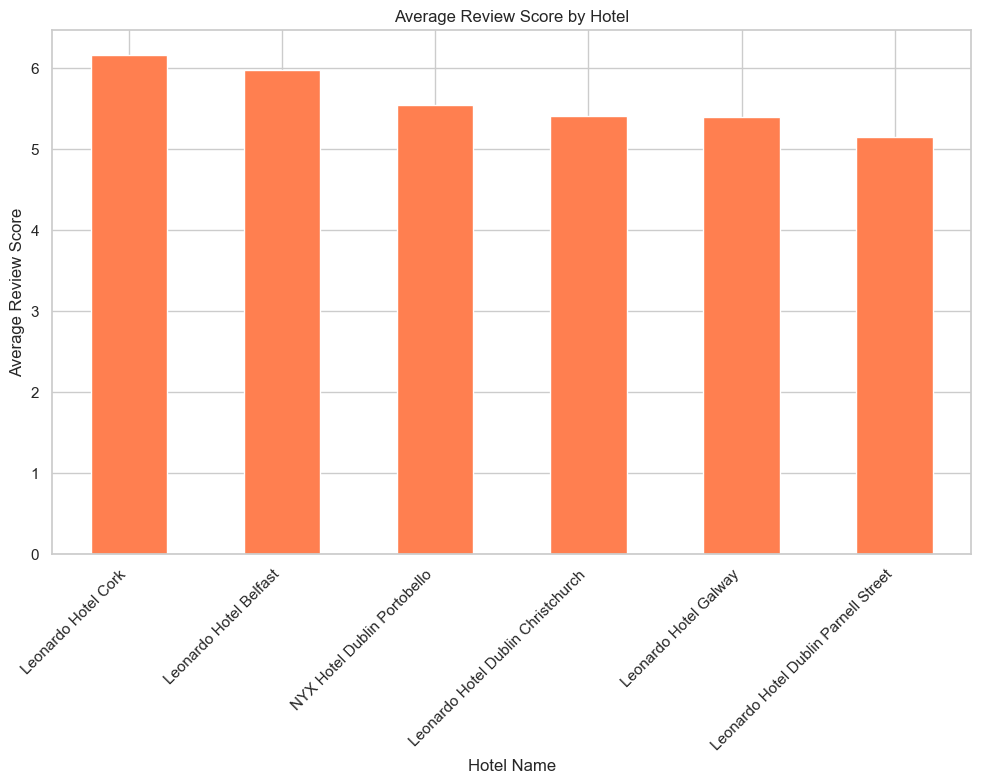

In [9]:
import seaborn as sns

# Calculating average review scores
average_scores = df.groupby('hotel_name')['review_score'].mean().sort_values(ascending=False)

sns.set(style="whitegrid")

# Creating a bar plot
plt.figure(figsize=(10, 8))
average_scores.plot(kind='bar', color='coral')
plt.title('Average Review Score by Hotel')
plt.xlabel('Hotel Name')
plt.ylabel('Average Review Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Reviews count by Nationality

<ipython-input-20-dedd486f9b9e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_counts.index, y=review_counts.values, palette='viridis')


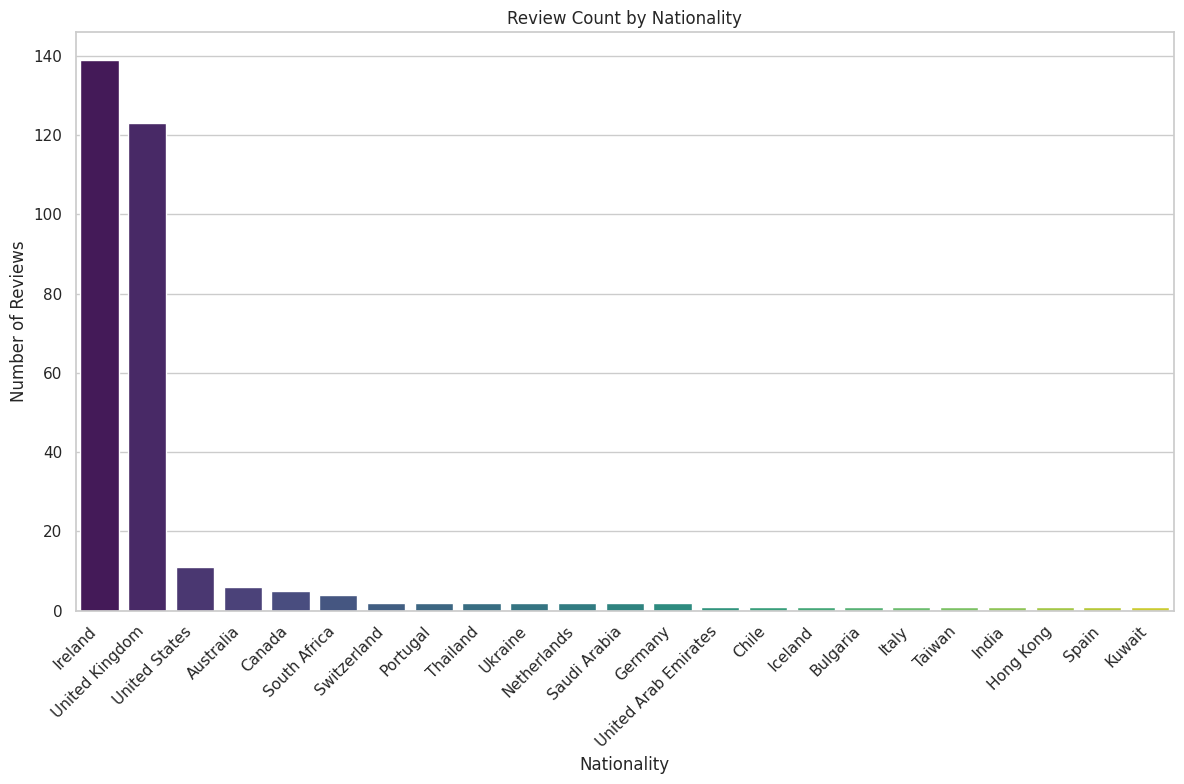

In [20]:
review_counts = df['nationality'].value_counts()

sns.set(style="whitegrid")

# Creating a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=review_counts.index, y=review_counts.values, palette='viridis')
plt.title('Review Count by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.tight_layout()  # padding
plt.show()

### Wordcloud of Negative Review

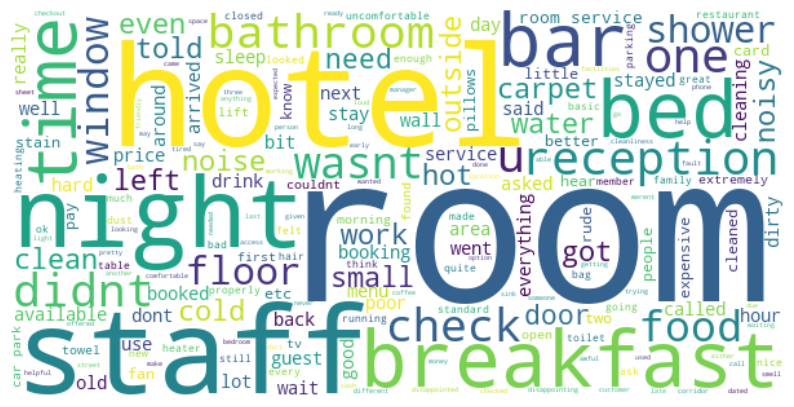

In [17]:
# Creating a wordcloud of the negative reviews to identify the classes(areas of issue).
from wordcloud import WordCloud

# Combining the filtered reviews into a single text
text = ' '.join(review for review in df['negative_review'])

# Generating and display the wordcloud
wordcloud = WordCloud(background_color='white', width=600, height=300).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



### Labelling classes to the dataframe

We have noted down the keywords for staff and quality issues after analysing the review file manually. Now we are going to label it on to the dataframe.

In [18]:
# Classification of reviews and labelling

def classify_review(review, staff_keywords, quality_keywords):
    review_lower = review.lower()
    if any(keyword in review_lower for keyword in staff_keywords):
        return 'Staff'
    elif any(keyword in review_lower for keyword in quality_keywords):
        return 'Quality'
    else:
        return 'Other'

staff_keywords = [
    'staff', 'service', 'manager', 'unprofessional', 'rude', 'disrespectful', 'ineffectual', 'slow',
    'attitude', 'unhelpful', 'dismissive', 'impolite', 'housekeeping', 'neglectful', 'indifferent',
    'lazy', 'unattentive', 'inefficient', 'disorganized', 'ignored'
]


quality_keywords = [
    'compact', 'dirty', 'creaky', 'noisy', 'hot', 'cleanliness'
    'outdated', 'smelly', 'broken', 'poor', 'bad', 'bathroom'
    'terrible', 'uncomfortable', 'small', 'air', 'breakfast', 'pillow'
]


# Classifying each review
df['review_category'] = df['negative_review'].apply(lambda review: classify_review(review, staff_keywords, quality_keywords))


In [19]:
# Category Distribution of reviews

category_distribution = df['review_category'].value_counts()
print(category_distribution)


review_category
Quality    131
Other      117
Staff       85
Name: count, dtype: int64


## Machine Learning Model

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Defining text, categorical, and numerical columns for scaling and encoding
text_features = 'negative_review'
categorical_features = ['hotel_name', 'nationality']
numerical_features = ['review_score']

X = df[['negative_review', 'hotel_name', 'nationality', 'review_score']]
y = df['review_category']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a column transformer for preprocessing different text and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('vect', TfidfVectorizer(stop_words='english'), text_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


### Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model Pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Training the model
pipeline_rf.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred_rf = pipeline_rf.predict(X_test)

rf_accuracy = round(accuracy_score(y_test, y_pred_rf),2)*100

print(f'Classification Report for Random Forest:\n{classification_report(y_test, y_pred_rf)}\n')
print(f'Random Forest Accuracy: {rf_accuracy}%')

Classification Report for Random Forest:
              precision    recall  f1-score   support

       Other       0.77      0.92      0.84        25
     Quality       0.83      0.79      0.81        24
       Staff       1.00      0.78      0.88        18

    accuracy                           0.84        67
   macro avg       0.86      0.83      0.84        67
weighted avg       0.85      0.84      0.84        67


Random Forest Accuracy: 84.0%


### Gradient Boosting Classifier

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Model Pipeline
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Training the model
pipeline_gb.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred_gb = pipeline_gb.predict(X_test)

gb_accuracy = round(accuracy_score(y_test, y_pred_gb),2)*100

print(f'Classification Report for Gradient Boosting:\n{classification_report(y_test, y_pred_gb)}\n')
print(f'Gradient Boosting Accuracy: {gb_accuracy}%')


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

       Other       0.77      0.96      0.86        25
     Quality       0.90      0.75      0.82        24
       Staff       1.00      0.89      0.94        18

    accuracy                           0.87        67
   macro avg       0.89      0.87      0.87        67
weighted avg       0.88      0.87      0.87        67


Gradient Boosting Accuracy: 87.0%


### Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Model Pipeline
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Training the model
pipeline_dt.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred_dt = pipeline_dt.predict(X_test)

dt_accuracy = round(accuracy_score(y_test, y_pred_dt),2)*100

print(f'Classification Report for Decision Tree:\n{classification_report(y_test, y_pred_dt)}\n')
print(f'Decision Tree Accuracy: {dt_accuracy}%')

Classification Report for Decision Tree:
              precision    recall  f1-score   support

       Other       0.77      0.92      0.84        25
     Quality       0.86      0.75      0.80        24
       Staff       1.00      0.89      0.94        18

    accuracy                           0.85        67
   macro avg       0.87      0.85      0.86        67
weighted avg       0.86      0.85      0.85        67


Decision Tree Accuracy: 85.0%


### Comparing Models

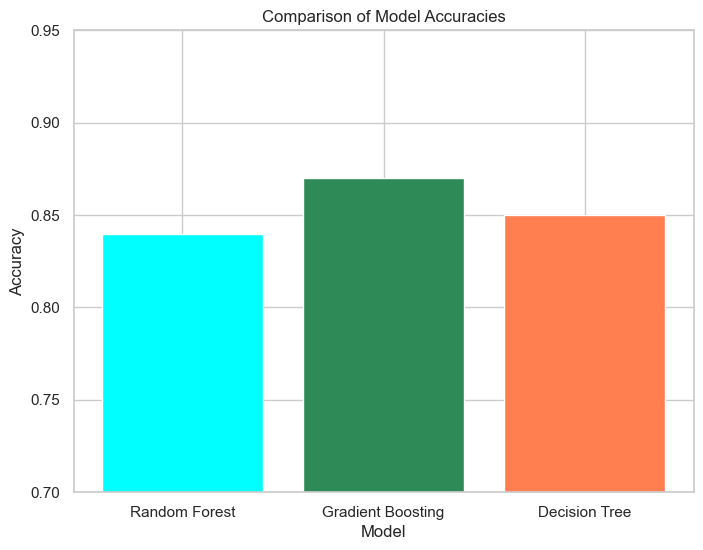

In [25]:
# Accuracy scores and values from the models
accuracies = {
    'Random Forest': rf_accuracy/100,
    'Gradient Boosting': gb_accuracy/100,
    'Decision Tree': dt_accuracy/100
}

models = list(accuracies.keys())

# Accuracy values
accuracy_values = [accuracies[model] for model in models]

# Creating bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_values, color=['cyan', 'seagreen', 'coral'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0.7, 0.95])
plt.show()

### Confusion Matrix

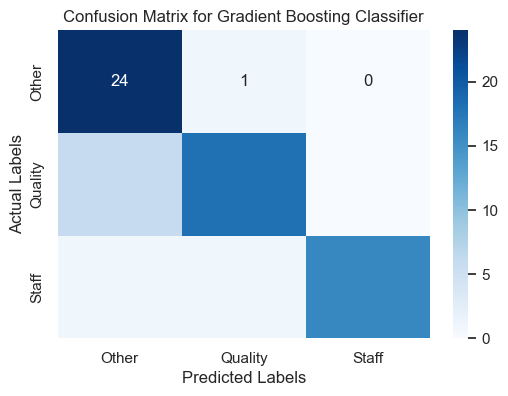

In [26]:
from sklearn.metrics import confusion_matrix

# Generating the confusion matrix for gradient boosting
cm = confusion_matrix(y_test, y_pred_gb)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Other', 'Quality', 'Staff'], yticklabels=['Other', 'Quality', 'Staff'])
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Pickle code to save the models

In [49]:
import pickle

# Saving all the three models using pickle library

with open('Random_Forest_Classifier.pkl', 'wb') as file:
    pickle.dump(y_pred_rf, file)
with open('Gradient_Boosting.pkl', 'wb') as file:
    pickle.dump(y_pred_gb, file)
with open('Decision_Tree.pkl', 'wb') as file:
    pickle.dump(y_pred_dt, file)